本记录是对使用的决策树方法的调参记录，主要内容是对K值的更换测试

由于本人能力有限，参与的项目相对较少，调出的结果想必不是最好的，还希望各位多加指教

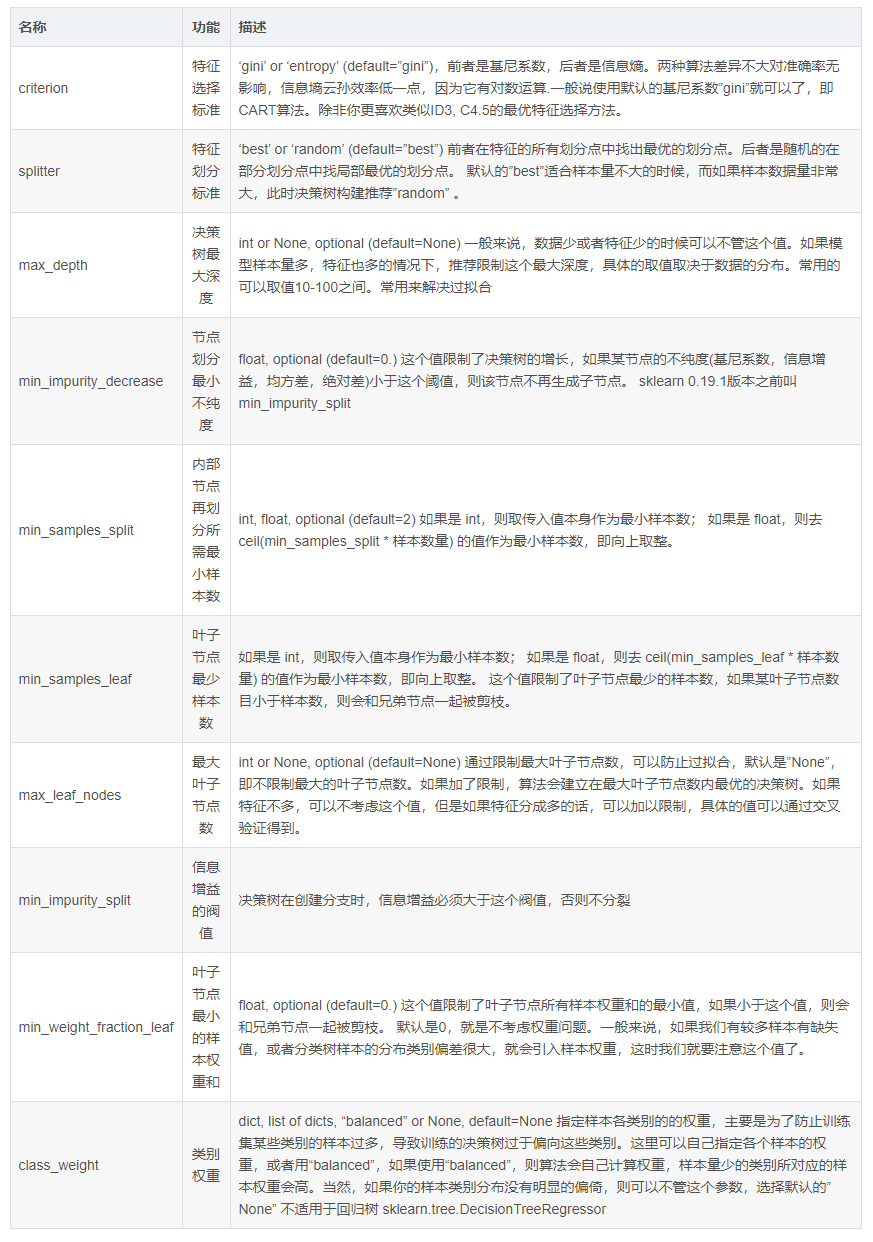

可能调整的值

splitter -》 random？

max_leaf_nodes 交叉测试解决

class_weight -》 balance 解决样本分布不平衡问题

事先进行PAC主成分分析

In [1]:
# coding=utf-8
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz # doctest: +SKIP
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
import snowballstemmer
from nltk import SnowballStemmer

sms_data = pd.read_csv("E:/finalpaper/smm.csv",encoding = 'latin-1')

#设置字体并显示中文
plt.rcParams['font.family'] = 'SimHei'

sms_data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
sms = sms_data.rename(columns = {'v1':'label','v2':'message'})

#去掉所有重复行
sms = sms.drop_duplicates()
sms.to_csv("E:/finalpaper/smm_drop.csv",encoding = 'latin-1',index = False)

#添加长度特征
sms['length'] = sms['message'].apply(len)
text_feat = sms['message'].copy()

def stemmer(text):
    text = text.split()
    words = ""
    for i in text:
        stemmer = SnowballStemmer("english")
        words += (stemmer.stem(i))+" "
    return words
text_feat = text_feat.apply(stemmer)

vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc


C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


DecisionTree


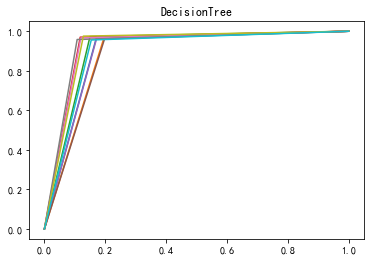

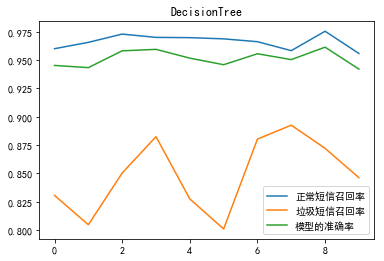

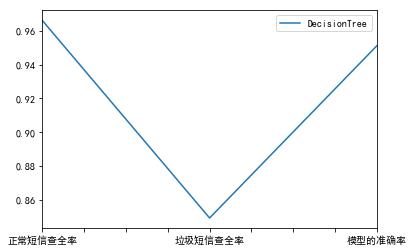

In [2]:
dtc = DecisionTreeClassifier(min_samples_split = 7,splitter = "random",class_weight = "balanced")
clfs = {'DecisionTree':dtc}
a = []
count_list_store = []
figure_count = 0
key = 'DecisionTree'
model = clfs[key]
score = []
hrecall = []
precall = []
b = []

plt.figure(figure_count)
print(key)

for i in range(10):
    features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
    model.fit(features_train,labels_train)
    score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
    cmat = confusion_matrix(model.predict(features_test),labels_test)
    fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
    hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
    precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
    recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

    plt.plot(fpr,tpr)

b.append(np.mean(recall.iloc[:,0]))
b.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
b.append(np.mean(recall.iloc[:,2]))
a.append((key,b)) 

plt.title(key)
plt.show()
figure_count = figure_count + 1

plt.figure(figure_count)
plt.plot(recall.iloc[:,0])
plt.plot(recall.iloc[:,1])
plt.plot(recall.iloc[:,2])
plt.title(key)
plt.legend()
plt.show()

figure_count = figure_count + 1

count_list = pd.DataFrame()
count_list['正常短信查全率'] = recall.iloc[:,0]
count_list['垃圾短信查全率'] = recall.iloc[:,1]
count_list['模型准确率'] = recall.iloc[:,2]
count_list_store.append(count_list)
    
data = pd.DataFrame(dict(a),index = [u'正常短信查全率',u'垃圾短信查全率',u'模型的准确率'])
data.plot()
plt.show()

In [21]:
max_leaf_nodes_store = []
for max_leaf_nodes_count in range(60):
    max_leaf_nodes_count = max_leaf_nodes_count + 10
    dtc = DecisionTreeClassifier(min_samples_split = 7,splitter = "random",class_weight = "balanced",max_leaf_nodes = max_leaf_nodes_count)
    clfs = {'DecisionTree':dtc}
    a = []
    key = 'DecisionTree'
    model = clfs[key]
    score = []
    hrecall = []
    precall = []
    b = []
    
    for i in range(10):
        features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
        model.fit(features_train,labels_train)
        score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
        cmat = confusion_matrix(model.predict(features_test),labels_test)
        fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
        hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
        precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
        recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

        plt.plot(fpr,tpr)
    print("垃圾短信查全率")
    print((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
    print("min_samples_split_count：")
    print(max_leaf_nodes_count)
    max_leaf_nodes_store.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
    print('\n')

垃圾短信查全率
0.8382770706154027
min_samples_split_count：
10


垃圾短信查全率
0.8604612341754904
min_samples_split_count：
11


垃圾短信查全率
0.8775902885140925
min_samples_split_count：
12


垃圾短信查全率
0.8609732338669139
min_samples_split_count：
13


垃圾短信查全率
0.8638386225564293
min_samples_split_count：
14


垃圾短信查全率
0.8870401751864171
min_samples_split_count：
15


垃圾短信查全率
0.8733154712343734
min_samples_split_count：
16


垃圾短信查全率
0.9013423919703636
min_samples_split_count：
17


垃圾短信查全率
0.8872347043359425
min_samples_split_count：
18


垃圾短信查全率
0.8914993712903291
min_samples_split_count：
19


垃圾短信查全率
0.8777677692565057
min_samples_split_count：
20


垃圾短信查全率
0.8918943521331677
min_samples_split_count：
21


垃圾短信查全率
0.8871400955571488
min_samples_split_count：
22


垃圾短信查全率
0.8796264009534797
min_samples_split_count：
23


垃圾短信查全率
0.884277726919598
min_samples_split_count：
24


垃圾短信查全率
0.871822225661697
min_samples_split_count：
25


垃圾短信查全率
0.8773168241575398
min_samples_split_count：
26


垃圾短信查全率
0.8875512662603104
min_sa

In [24]:
np.mean(max_leaf_nodes_store)
max(max_leaf_nodes_store)

0.9013423919703636

In [25]:
max_leaf_nodes_store = []
for max_leaf_nodes_count in range(20):
    max_leaf_nodes_count = 46
    dtc = DecisionTreeClassifier(min_samples_split = 7,splitter = "random",class_weight = "balanced",max_leaf_nodes = 27)
    clfs = {'DecisionTree':dtc}
    a = []
    key = 'DecisionTree'
    model = clfs[key]
    score = []
    hrecall = []
    precall = []
    b = []
    
    for i in range(10):
        features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
        model.fit(features_train,labels_train)
        score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
        cmat = confusion_matrix(model.predict(features_test),labels_test)
        fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
        hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
        precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
        recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

        plt.plot(fpr,tpr)
    print("垃圾短信查全率")
    print((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
    print("min_samples_split_count：")
    print(max_leaf_nodes_count)
    max_leaf_nodes_store.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
    print('\n')

垃圾短信查全率
0.8816149816430255
min_samples_split_count：
46


垃圾短信查全率
0.8833361400716144
min_samples_split_count：
46


垃圾短信查全率
0.8905605074411521
min_samples_split_count：
46


垃圾短信查全率
0.8931834840431842
min_samples_split_count：
46


垃圾短信查全率
0.8795396538799862
min_samples_split_count：
46


垃圾短信查全率
0.8831341706000253
min_samples_split_count：
46


垃圾短信查全率
0.8972107107373388
min_samples_split_count：
46


垃圾短信查全率
0.8833030279556422
min_samples_split_count：
46


垃圾短信查全率
0.892831734554594
min_samples_split_count：
46


垃圾短信查全率
0.8877005066045215
min_samples_split_count：
46


垃圾短信查全率
0.8870307277211141
min_samples_split_count：
46


垃圾短信查全率
0.8692124101721475
min_samples_split_count：
46


垃圾短信查全率
0.8921763344519389
min_samples_split_count：
46


垃圾短信查全率
0.8884901003665312
min_samples_split_count：
46


垃圾短信查全率
0.883688836728852
min_samples_split_count：
46


垃圾短信查全率
0.8854014867114698
min_samples_split_count：
46


垃圾短信查全率
0.8786557056327631
min_samples_split_count：
46


垃圾短信查全率
0.8978894178377366
min_sa

In [27]:
np.mean(max_leaf_nodes_store)
#max(max_leaf_nodes_store)

0.885758345732081

min_samples_split取7是最佳的已经确定了，明天测试max_leaf_nodes